# Translation of Numeric Phrases with Seq2Seq

In the following we will try to build a **translation model from english phrases describing numbers** to the corresponding **numeric representation** (base 10).

This is a toy machine translation task with a **restricted vocabulary** and a **single valid translation for each source phrase** which makes it more tractable to train on a laptop computer and easier to evaluate. Despite those limitations we expect that this task will highlight interesting properties of Seq2Seq models including:

- the ability to **deal with different length** of the source and target sequences,
- handling token with a **meaning that changes depending on the context** (e.g "one" as a number or as a pronoun),
- basic counting and "reasoning" capabilities of LSTM and GRU models.

The parallel text data is generated from a "ground-truth" Python function named `to_english_phrase` that captures common rules. Hyphenation was intentionally omitted to make the phrases more ambiguous and therefore make the translation problem slightly harder to solve (and also because Olivier had no particular interest hyphenation in properly implementing rules :).

In [2]:
from english_numbers import to_english_phrase
    
for x in [21, 80, 81, 300, 213, 1100, 1201, 301000, 80080]:
    print(str(x).rjust(6), to_english_phrase(x))

    21 twenty one
    80 eighty
    81 eighty one
   300 three hundred
   213 two hundred thirteen
  1100 one thousand one hundred
  1201 one thousand two hundred one
301000 three hundred one thousand
 80080 eighty thousand eighty


## Generating a Training Set

The following will **generate phrases 20000 example phrases for numbers between 1 and 1,000,000** (excluded). We chose to over-represent small numbers by generating all the possible short sequences between `1` and `exhaustive=5000`.

We then split the generated set into non-overlapping train, validation and test splits.

In [3]:
from english_numbers import generate_translations
from sklearn.model_selection import train_test_split

numbers, english_numbers = generate_translations(
    low=1, high=int(1e6) - 1, exhaustive=5000, random_seed=0)
num_train, num_dev, en_train, en_dev = train_test_split(
    numbers, english_numbers, test_size=0.5, random_state=0)

num_val, num_test, en_val, en_test = train_test_split(
    num_dev, en_dev, test_size=0.5, random_state=0)

In [4]:
len(en_train), len(en_val), len(en_test)

(10000, 5000, 5000)

In [5]:
for i, en_phrase, num_phrase in zip(range(5), en_train, num_train):
    print(num_phrase.rjust(6), en_phrase)

  2882 two thousand eight hundred eighty two
372200 three hundred seventy two thousand two hundred
  2193 two thousand one hundred ninety three
996418 nine hundred ninety six thousand four hundred eighteen
  9172 nine thousand one hundred seventy two


In [6]:
for i, en_phrase, num_phrase in zip(range(5), en_val, num_val):
    print(num_phrase.rjust(6), en_phrase)

  2804 two thousand eight hundred four
  3898 three thousand eight hundred ninety eight
 82996 eighty two thousand nine hundred ninety six
366346 three hundred sixty six thousand three hundred forty six
 56006 fifty six thousand six


## Vocabularies

Build the vocabularies from the training set only to get a chance to have some out-of-vocabulary words in the validation and test sets.

First we need to introduce specific symbols that will be used to:
- pad sequences
- mark the beginning of translation
- mark the end of translation
- be used as a placehold for out-of-vocabulary symbols (not seen in the training set).

Here we use the same convention as the [tensorflow seq2seq tutorial](https://www.tensorflow.org/tutorials/seq2seq):

In [7]:
PAD, GO, EOS, UNK = START_VOCAB = ['_PAD', '_GO', '_EOS', '_UNK'] # "pad" i used instead of spaces

To build the vocabulary we need to tokenize the sequences of symbols. For the digital number representation we use character level tokenization while whitespace-based word level tokenization will do for the english phrases:

In [8]:
def tokenize(sentence, word_level=True):
    if word_level:
        return sentence.split()
    else:
        return [sentence[i:i + 1] for i in range(len(sentence))]

In [9]:
tokenize('1234', word_level=False)

['1', '2', '3', '4']

In [10]:
tokenize('one thousand two hundred thirty four', word_level=True)

['one', 'thousand', 'two', 'hundred', 'thirty', 'four']

Let's now use this tokenization strategy to assign a unique integer token id to each possible token string found the traing set in each language ('english' and 'numeric'): 

In [11]:
def build_vocabulary(tokenized_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary

In [12]:
tokenized_en_train = [tokenize(s, word_level=True) for s in en_train]
tokenized_num_train = [tokenize(s, word_level=False) for s in num_train]

en_vocab, rev_en_vocab = build_vocabulary(tokenized_en_train)
num_vocab, rev_num_vocab = build_vocabulary(tokenized_num_train)

The two languages do not have the same vocabulary sizes:

In [13]:
len(en_vocab)

33

In [14]:
len(num_vocab)

14

In [15]:
for k, v in sorted(en_vocab.items())[:10]:
    print(f'{k:10}: {v}')

_EOS      : 2
_GO       : 1
_PAD      : 0
_UNK      : 3
eight     : 4
eighteen  : 5
eighty    : 6
eleven    : 7
fifteen   : 8
fifty     : 9


In [16]:
for k, v in sorted(num_vocab.items()):
    print(f'{k:10}: {v}')

0         : 4
1         : 5
2         : 6
3         : 7
4         : 8
5         : 9
6         : 10
7         : 11
8         : 12
9         : 13
_EOS      : 2
_GO       : 1
_PAD      : 0
_UNK      : 3


We also built the reverse mappings from token ids to token string representations:

In [17]:
print(rev_en_vocab)

['_PAD', '_GO', '_EOS', '_UNK', 'eight', 'eighteen', 'eighty', 'eleven', 'fifteen', 'fifty', 'five', 'forty', 'four', 'fourteen', 'hundred', 'nine', 'nineteen', 'ninety', 'one', 'seven', 'seventeen', 'seventy', 'six', 'sixteen', 'sixty', 'ten', 'thirteen', 'thirty', 'thousand', 'three', 'twelve', 'twenty', 'two']


In [18]:
print(rev_num_vocab)

['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Seq2Seq with a single GRU architecture

<img src="images/basic_seq2seq.png" width="80%" />

From: [Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." NIPS 2014](https://arxiv.org/abs/1409.3215)



For a given source sequence - target sequence pair, we will:
- tokenize the source and target sequences;
- reverse the order of the source sequence;
- build the input sequence by concatenating the reversed source sequence and the target sequence in original order using the `_GO` token as a delimiter, 
- build the output sequence by appending the `_EOS` token to the source sequence.


Let's do this as a function using the original string representations for the tokens so as to make it easier to debug:

**Exercise**
- Write a function that turns a pair of tokenized (source, target) sequences into a pair of (input, output) sequences as described above.
- The function should have a `reverse_source=True` as an option.

For example:

```python
input_tokens, output_tokens = make_input_output(
    ['one', 'hundred', 'twenty', 'two'],
    ['1', '2', '2'],
    reverse_source=True
)
==> input_tokens == ['two', 'twenty', 'hundred', 'one', '_GO', '1', '2', '2']
==> output_tokens == ['1', '2', '2', '_EOS']

input_tokens, output_tokens = make_input_output(
    ['one', 'hundred', 'twenty', 'two'],
    ['1', '2', '2'],
    reverse_source=False)
==> input_tokens == ['one', 'hundred', 'twenty', 'two', '_GO', '1', '2', '2']
==> output_tokens == ['1', '2', '2', '_EOS']
```


Notes: 
- The function should output two sequences of string tokens: one to be fed as the input and the other as expected output for the seq2seq network.
- Do not pad the sequences: we will handle the padding later.
- Don't forget to insert the `_GO` and `_EOS` special symbols at the right locations.

In [19]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    # Your code here
   return_tokens = source_tokens
   if(reverse_source):
    return_tokens.reverse()
    return_tokens.append('_GO')
    return_tokens.extend(target_tokens)
    target_tokens.append('_EOS')
    return source_tokens , target_tokens

In [20]:
input_tokens, output_tokens = make_input_output(
    ['one', 'hundred', 'twenty', 'one'],
    ['1', '2', '1'],
)

In [21]:
input_tokens

['one', 'twenty', 'hundred', 'one', '_GO', '1', '2', '1']

In [22]:
output_tokens

['1', '2', '1', '_EOS']

### Vectorization of the parallel corpus

Let's apply the previous transformation to each pair of (source, target) sequene and use a shared vocabulary to store the results in numpy arrays of integer token ids, with padding on the left so that all input / output sequences have the same length: 

In [23]:
all_tokenized_sequences = tokenized_en_train + tokenized_num_train
shared_vocab, rev_shared_vocab = build_vocabulary(all_tokenized_sequences)

In [24]:
max(len(s) for s in tokenized_en_train)

9

In [25]:
max(len(s) for s in tokenized_num_train)

6

In [26]:
import numpy as np
max_length = 20  # found by introspection of our training set

def vectorize_corpus(source_sequences, target_sequences, shared_vocab,
                     word_level_source=True, word_level_target=True,
                     max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    source_ids.fill(shared_vocab[PAD])
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(shared_vocab[PAD])
    numbered_pairs = zip(range(n_sequences), source_sequences, target_sequences)
    for i, source_seq, target_seq in numbered_pairs:
        source_tokens = tokenize(source_seq, word_level=word_level_source)
        target_tokens = tokenize(target_seq, word_level=word_level_target)
        
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        
        in_token_ids = [shared_vocab.get(t, UNK) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
    
        out_token_ids = [shared_vocab.get(t, UNK) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids
    return source_ids, target_ids

In [27]:
X_train, Y_train = vectorize_corpus(en_train, num_train, shared_vocab,
                                    word_level_target=False)

In [28]:
X_train.shape

(10000, 20)

In [29]:
X_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 42, 16, 24, 14, 38, 42,  1,  6,
       12, 12,  6], dtype=int32)

In [30]:
Y_train.shape

(10000, 20)

In [31]:
en_train[0]

'two thousand eight hundred eighty two'

In [32]:
num_train[0]

'2882'

In [33]:
X_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 42, 16, 24, 14, 38, 42,  1,  6,
       12, 12,  6], dtype=int32)

In [34]:
Y_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 12,
       12,  6,  2], dtype=int32)

This looks good. In particular we can note:

- the PAD=0 symbol at the beginning of the two sequences,
- the input sequence has the GO=1 symbol to separate the source from the target,
- the output sequence is a shifted version of the target and ends with EOS=2.

Let's vectorize the validation and test set to be able to evaluate our models:

In [35]:
X_val, Y_val = vectorize_corpus(en_val, num_val, shared_vocab,
                                word_level_target=False)
X_test, Y_test = vectorize_corpus(en_test, num_test, shared_vocab,
                                  word_level_target=False)

In [36]:
X_val.shape, Y_val.shape

((5000, 20), (5000, 20))

In [37]:
X_test.shape, Y_test.shape

((5000, 20), (5000, 20))

### A simple homogeneous Seq2Seq architecture

To keep the architecture simple we will use the **same RNN model and weights for both the encoder part** (before the `_GO` token) **and the decoder part** (after the `_GO` token).

We may GRU recurrent cell instead of LSTM because it is slightly faster to compute and should give comparable results.

**Exercise:**
- Build a Seq2Seq model:
  - Start with an Embedding layer;
  - Add a single GRU layer: the GRU layer should yield a sequence of output vectors, one at each timestep;
  - Add a Dense layer to adapt the ouput dimension of the GRU layer to the dimension of the output vocabulary;
  - Don't forget to insert some Dropout layer(s), especially after the Embedding layer.

Note:
- The output dimension of the Embedding layer should be smaller than usual be cause we have small vocabulary size;
- The dimension of the GRU should be larger to give the Seq2Seq model enough "working memory" to memorize the full input sequence before decoding it;
- Your model should output a shape `[batch, sequence_length, vocab_size]`.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GRU, Dense

VOCAB_SIZE = len(shared_vocab)
embedding_size = 64
input_length = 20


simple_seq2seq = Sequential([
    # Your Code
    Embedding(input_dim = input_length ,output_dim=embedding_size),
    Dropout(rate = 0.5, noise_shape=None, seed=None),
    GRU(4, return_sequences = True, reset_after=False),
    Dense(14,activation="softmax")

])

model = simple_seq2seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

2024-04-27 19:35:17.489905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's register a callback mechanism to automatically snapshot the best model by measure the performance of the model on the validation set at the end of each epoch during training:

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


best_model_fname = "simple_seq2seq_checkpoint.keras"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss',
                                save_best_only=True, verbose=1)

We need to use np.expand_dims trick on Y: this is required by Keras because we use a sparse (integer-based) representation for the output:

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.91068, saving model to simple_seq2seq_checkpoint.keras
313/313 - 5s - 15ms/step - loss: 1.3556 - val_loss: 0.9107
Epoch 2/15

Epoch 2: val_loss improved from 0.91068 to 0.73823, saving model to simple_seq2seq_checkpoint.keras
313/313 - 2s - 7ms/step - loss: 0.8080 - val_loss: 0.7382
Epoch 3/15

Epoch 3: val_loss improved from 0.73823 to 0.68034, saving model to simple_seq2seq_checkpoint.keras
313/313 - 2s - 7ms/step - loss: 0.7086 - val_loss: 0.6803
Epoch 4/15

Epoch 4: val_loss improved from 0.68034 to 0.65240, saving model to simple_seq2seq_checkpoint.keras
313/313 - 2s - 7ms/step - loss: 0.6675 - val_loss: 0.6524
Epoch 5/15

Epoch 5: val_loss improved from 0.65240 to 0.63806, saving model to simple_seq2seq_checkpoint.keras
313/313 - 2s - 7ms/step - loss: 0.6466 - val_loss: 0.6381
Epoch 6/15

Epoch 6: val_loss improved from 0.63806 to 0.62866, saving model to simple_seq2seq_checkpoint.keras
313/313 - 2s - 7ms/step - loss: 0.6347 - 

Text(0.5, 1.0, 'Convergence plot for Simple Seq2Seq')

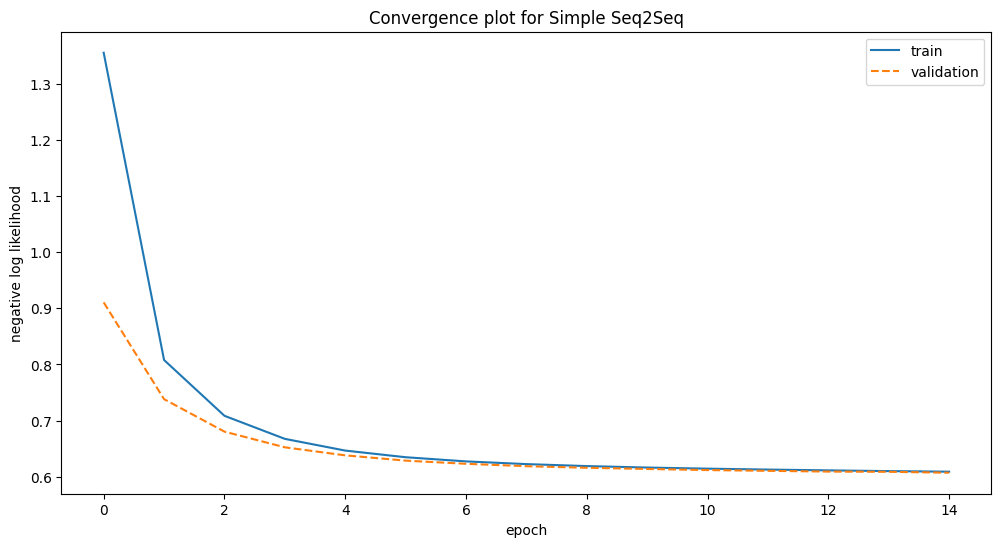

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

history = simple_seq2seq.fit(X_train, np.expand_dims(Y_train, -1),
                             validation_data=(X_val, np.expand_dims(Y_val, -1)),
                             epochs=15, verbose=2, batch_size=32,
                             callbacks=[best_model_cb])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], '--', label='validation')
plt.ylabel('negative log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Convergence plot for Simple Seq2Seq')

Let's load the best model found on the validation set at the end of training:

In [41]:
simple_seq2seq = load_model(best_model_fname)

Let's have a look at a raw prediction on the first sample of the test set:

In [42]:
en_test[0]

'ninety six thousand two hundred thirty seven'

In numeric array this is provided (along with the expected target sequence) as the following padded input sequence:

In [43]:
first_test_sequence = X_test[0:1]
first_test_sequence

array([[ 0,  0,  0,  0,  0,  0,  0, 29, 37, 24, 42, 38, 32, 27,  1, 13,
        10,  6,  7, 11]], dtype=int32)

Remember that the `_GO` (symbol indexed at `1`) separates the reversed source from the expected target sequence:  

In [44]:
rev_shared_vocab[1]

'_GO'

To use the model to make new predictions, we need to write a method that successively predicts one token at a time until the end of sequence symbol is reached. This is provided for you below:

In [45]:
def greedy_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                     word_level_source=True, word_level_target=True):
    """Greedy decoder recursively predicting one token at a time"""
    
    # Initialize the list of input token ids with the source sequence
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK) for t in reversed(source_tokens)]
    input_ids += [shared_vocab[GO]]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(1, model.input_shape[1]),
                           dtype=np.int32)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        # Vectorize the list of input tokens and use zero padding.
        input_array.fill(shared_vocab[PAD])
        input_array[0, -len(input_ids):] = input_ids
        
        # Predict the next output: greedy decoding with argmax
        next_token_id = model(input_array)[0, -1].numpy().argmax()
        
        # Stop decoding if the network predicts end of sentence:
        if next_token_id == shared_vocab[EOS]:
            break
            
        # Otherwise use the reverse vocabulary to map the prediction
        # back to the string space
        decoded_tokens.append(rev_shared_vocab[next_token_id])
        
        # Append prediction to input sequence to predict the next
        input_ids.append(next_token_id)

    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)

In [46]:
phrases = [
    "one",
    "two",
    "three",
    "eleven",
    "fifteen",
    "one hundred thirty two",
    "one hundred thousand twelve",
    "seven thousand eight hundred fifty nine",
    "twenty one",
    "twenty four",
    "eighty",
    "ninety one thousand",
    "ninety one thousand two hundred two",
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase,
                                   shared_vocab, rev_shared_vocab,
                                   word_level_target=False)
    print(phrase.ljust(40), translation)

one                                      342
two                                      342
three                                    342
eleven                                   342
fifteen                                  342
one hundred thirty two                   342
one hundred thousand twelve              342
seven thousand eight hundred fifty nine  342
twenty one                               342
twenty four                              342
eighty                                   342
ninety one thousand                      342
ninety one thousand two hundred two      342


The results are far from perfect but we can see that the network has already picked up some translation skills. Let's see what happens when we try to translate some phrases that were not in the training set:

In [47]:
phrases = [
    "one hundred twenty three",
    "eleven thousand two hundred thirty four",
    "fourteen hundred"
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase,
                                   shared_vocab, rev_shared_vocab,
                                   word_level_target=False)
    print(phrase.ljust(40), translation)

one hundred twenty three                 342
eleven thousand two hundred thirty four  342
fourteen hundred                         342


## Model evaluation

Because **we expect only one correct translation** for a given source sequence, we can use **phrase-level accuracy** as a metric to quantify our model quality.

Note that **this is not the case for real translation models** (e.g. from English to French on arbitrary sentences). Evaluation of a machine translation model is tricky in general. Automated evaluation can somehow be done at the corpus level with the [BLEU score](https://en.wikipedia.org/wiki/BLEU) (bilingual evaluation understudy) given a large enough sample of correct translations provided by certified translators but its only a noisy proxy.

The only good evaluation is to give a large enough sample of the model predictions on some test sentences to certified translators and ask them to give an evaluation (e.g. a score between 0 and 6, 0 for non-sensical and 6 for the hypothetical perfect translation). However in practice this is very costly to do.

Fortunately we can just use phrase-level accuracy on a our very domain specific toy problem:

In [48]:
def phrase_accuracy(model, num_sequences, en_sequences, n_samples=300,
                    decoder_func=greedy_translate):
    correct = []
    n_samples = len(num_sequences) if n_samples is None else n_samples
    for i, num_seq, en_seq in zip(range(n_samples), num_sequences, en_sequences):
        if i % 100 == 0:
            print("Decoding %d/%d" % (i, n_samples))

        predicted_seq = decoder_func(simple_seq2seq, en_seq,
                                     shared_vocab, rev_shared_vocab,
                                     word_level_target=False)
        correct.append(num_seq == predicted_seq)
    return np.mean(correct)

In [49]:
print("Phrase-level train accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_train, en_train))

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level train accuracy: 0.000


In [50]:
print("Phrase-level test accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_test, en_test))

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level test accuracy: 0.000


## Conclusion

We've only scratched the surface of what can be done with Seq2Seq models. If you have time, see if you can improve the quality of the model further, to get a better accuracy on the test set.